# PRÁCTICA - million ENTRADAS
MIEMBROS DEL GRUPO: Álvaro Fraile, Esteban Martínez, Alejandro Mendoza, Jaime Alvarez

El cuaderno ha sido ejecutado sobre un contenedor de Docker, con 6 nucleos y 12 hilos.

In [1]:
%pip install numpy tqdm matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import findspark
findspark.init()
import random
from pyspark import SparkContext
import pyspark
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [3]:
num_cores = os.cpu_count()
print(f"Número de núcleos de CPU: {num_cores}")

Número de núcleos de CPU: 12


In [4]:
file_path = './data/botnet_tot_syn_l.csv'

In [5]:
sc = SparkContext("local[*]", "Name of the Program")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/08 10:59:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:

def readFile(filename):
    rdd = sc.textFile(filename)
    rdd_numpy = rdd.map(lambda x : np.array(x.split(","), dtype = float))
    rdd_return = rdd_numpy.map(lambda x : (x[:-1], int(x[-1])))
    return rdd_return

def normalize_value(x, mean, std):
    value = (x[0] - mean) / std
    normalized_val = np.nan_to_num(value, copy=False, nan=0.0)
    return (normalized_val, x[1])

def normalize(RDD_Xy):
    
    rdd_sum = RDD_Xy.reduce(lambda x, y: (np.array(x[0]) + np.array(y[0]), x[1]))
    total_rows = float(RDD_Xy.count())
    mean = rdd_sum[0] / total_rows

    rdd_mean = RDD_Xy.map(lambda x: (x[0], x[1], mean)) 

    rdd_substract = rdd_mean.map(lambda x: (x[0] - x[2]) ** 2)
    rdd_total = rdd_substract.reduce(lambda x, y: x + y)
    std = (rdd_total / total_rows) ** 0.5
 

    rdd_normalized = RDD_Xy.map(lambda x: normalize_value(x, mean, std))
    return rdd_normalized

def predict(w, b, X, threshold=0.5):
    value = np.dot(w, X) + b
    value = 1 / (1 + np.exp(-value))
    return  1 if value > threshold else 0

def loss_function(x):
    return (-x[1] * np.log(x[0]) - (1 - x[1]) * np.log(1 - x[0]))

def calculate_loss_function(predictions_and_targets,lambda_reg,w):   
    """
    Calculate the loss function for logistic regression
    :param predictions_and_targets: RDD with the predictions and the targets
    :param lambda_reg: regularization parameter
    :param w: weights
    :return: loss function
    """

    loss = predictions_and_targets.map(loss_function)
    sum = loss.reduce(lambda x,y: x + y) / predictions_and_targets.count()
    squared_w = np.dot(w, w)
    squared_w = squared_w * lambda_reg / (2 * len(w))
    return sum + squared_w

def predict_train(w, b, X,):
    value = np.dot(w, X) + b
    return 1 / (1 + np.exp(-value))

def train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

def accuracy(w,b,RDD_Xy):
    predictions_and_targets = RDD_Xy.map(lambda x: (predict(w, b, x[0]), x[1]))
    correct = predictions_and_targets.map(lambda x: 1 if round(x[0]) == x[1] else 0)
    correct = correct.reduce(lambda x, y: x + y)
    return correct / predictions_and_targets.count()

def transform(data,num_blocks_cv):
    data = data.map(lambda x: (random.randint(0, num_blocks_cv-1), x[0], x[1]))
    return data

def get_block_data(data_cv: pyspark.rdd.RDD, i):
    train_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] != i else [])
    test_data = data_cv.flatMap(lambda x: [(x[1], x[2])] if x[0] == i else [])
    return train_data, test_data


## **EJERCICIO 1**

In [7]:
n = readFile(file_path)

normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")

Iteration: 0, Loss: [0.69266744]


Iteration: 1, Loss: [0.42708181]


Iteration: 2, Loss: [0.33431837]


Iteration: 3, Loss: [0.28991887]


Iteration: 4, Loss: [0.26411855]


Iteration: 5, Loss: [0.24717193]


Iteration: 6, Loss: [0.23510386]


Iteration: 7, Loss: [0.22601437]


Iteration: 8, Loss: [0.2188843]


Iteration: 9, Loss: [0.21311771]


Final accuracy: 0.927938


## **EJERCICIO 2**

In [8]:
num_blocks_cv=10
rdd_with_keys = transform(normalizado, num_blocks_cv)
rdd_with_keys.cache()
_ = rdd_with_keys.count() # to cache the data
all_ac=[]
for i in range(num_blocks_cv):
    train_data, test_data = get_block_data(rdd_with_keys, i)
    print("-"*50)
    print(f"Block {i}")
    w,b=train(train_data,10,1.5,0)
    acc=accuracy(w,b,test_data)
    all_ac.append(acc)
    print(f"Accuracy: {acc}")
print(f"Mean accuracy: {np.mean(all_ac)}")

--------------------------------------------------
Block 0


Iteration: 0, Loss: [0.78983893]


Iteration: 1, Loss: [0.50170576]


Iteration: 2, Loss: [0.37928105]


Iteration: 3, Loss: [0.31757448]


Iteration: 4, Loss: [0.28267163]


Iteration: 5, Loss: [0.2606143]


Iteration: 6, Loss: [0.24540586]


Iteration: 7, Loss: [0.23423303]


Iteration: 8, Loss: [0.22563589]


Iteration: 9, Loss: [0.2187876]
Accuracy: 0.9257614466488364
--------------------------------------------------
Block 1


Iteration: 0, Loss: [0.65429259]


Iteration: 1, Loss: [0.42541853]


Iteration: 2, Loss: [0.34086255]


Iteration: 3, Loss: [0.2978058]


Iteration: 4, Loss: [0.27142167]


Iteration: 5, Loss: [0.25345884]


Iteration: 6, Loss: [0.24038265]


Iteration: 7, Loss: [0.23041146]


Iteration: 8, Loss: [0.2225431]


Iteration: 9, Loss: [0.21616792]
Accuracy: 0.9275051810618423
--------------------------------------------------
Block 2


Iteration: 0, Loss: [0.78828777]


Iteration: 1, Loss: [0.49422401]


Iteration: 2, Loss: [0.36727402]


Iteration: 3, Loss: [0.30692295]


Iteration: 4, Loss: [0.27365627]


Iteration: 5, Loss: [0.25280682]


Iteration: 6, Loss: [0.23849516]


Iteration: 7, Loss: [0.22802721]


Iteration: 8, Loss: [0.22001164]


Iteration: 9, Loss: [0.21365935]
Accuracy: 0.928146425443233
--------------------------------------------------
Block 3


Iteration: 0, Loss: [0.78949656]


Iteration: 1, Loss: [0.49469731]


Iteration: 2, Loss: [0.37256658]


Iteration: 3, Loss: [0.31338849]


Iteration: 4, Loss: [0.27950088]


Iteration: 5, Loss: [0.25770291]


Iteration: 6, Loss: [0.24254269]


Iteration: 7, Loss: [0.23140281]


Iteration: 8, Loss: [0.22287528]


Iteration: 9, Loss: [0.21613667]
Accuracy: 0.9283389573308308
--------------------------------------------------
Block 4


Iteration: 0, Loss: [0.58918799]


Iteration: 1, Loss: [0.38187811]


Iteration: 2, Loss: [0.3103024]


Iteration: 3, Loss: [0.27541355]


Iteration: 4, Loss: [0.25429658]


Iteration: 5, Loss: [0.2398779]


Iteration: 6, Loss: [0.22928691]


Iteration: 7, Loss: [0.22112474]


Iteration: 8, Loss: [0.21461779]


Iteration: 9, Loss: [0.20929775]


Accuracy: 0.9291127328788379
--------------------------------------------------
Block 5


Iteration: 0, Loss: [0.67649383]


Iteration: 1, Loss: [0.43952978]


Iteration: 2, Loss: [0.33658773]


Iteration: 3, Loss: [0.28724589]


Iteration: 4, Loss: [0.25967956]


Iteration: 5, Loss: [0.24219339]


Iteration: 6, Loss: [0.23006114]


Iteration: 7, Loss: [0.22109927]


Iteration: 8, Loss: [0.21417394]


Iteration: 9, Loss: [0.20863949]
Accuracy: 0.9297605723878807
--------------------------------------------------
Block 6


Iteration: 0, Loss: [0.53476656]


Iteration: 1, Loss: [0.37446739]


Iteration: 2, Loss: [0.30541274]


Iteration: 3, Loss: [0.26969423]


Iteration: 4, Loss: [0.24833166]


Iteration: 5, Loss: [0.23416261]


Iteration: 6, Loss: [0.22405323]


Iteration: 7, Loss: [0.21644842]


Iteration: 8, Loss: [0.2104964]


Iteration: 9, Loss: [0.20569336]
Accuracy: 0.9303828990357798
--------------------------------------------------
Block 7


Iteration: 0, Loss: [0.63303697]


Iteration: 1, Loss: [0.40388]


Iteration: 2, Loss: [0.32518598]


Iteration: 3, Loss: [0.28649181]


Iteration: 4, Loss: [0.26288499]


Iteration: 5, Loss: [0.24673317]


Iteration: 6, Loss: [0.234894]


Iteration: 7, Loss: [0.22580771]


Iteration: 8, Loss: [0.21859942]


Iteration: 9, Loss: [0.2127351]
Accuracy: 0.9286421704464741
--------------------------------------------------
Block 8


Iteration: 0, Loss: [0.84791142]


Iteration: 1, Loss: [0.4853563]


Iteration: 2, Loss: [0.35156561]


Iteration: 3, Loss: [0.29712686]


Iteration: 4, Loss: [0.26794369]


Iteration: 5, Loss: [0.24943678]


Iteration: 6, Loss: [0.23648494]


Iteration: 7, Loss: [0.22683034]


Iteration: 8, Loss: [0.21931287]


Iteration: 9, Loss: [0.21326973]
Accuracy: 0.9285928652888098
--------------------------------------------------
Block 9


Iteration: 0, Loss: [0.72489322]


Iteration: 1, Loss: [0.46866554]


Iteration: 2, Loss: [0.35832644]


Iteration: 3, Loss: [0.30327098]


Iteration: 4, Loss: [0.27162236]


Iteration: 5, Loss: [0.25133983]


Iteration: 6, Loss: [0.23728604]


Iteration: 7, Loss: [0.2269781]


Iteration: 8, Loss: [0.21908708]


Iteration: 9, Loss: [0.21284253]
Accuracy: 0.9263445906812326
Mean accuracy: 0.9282587841203757


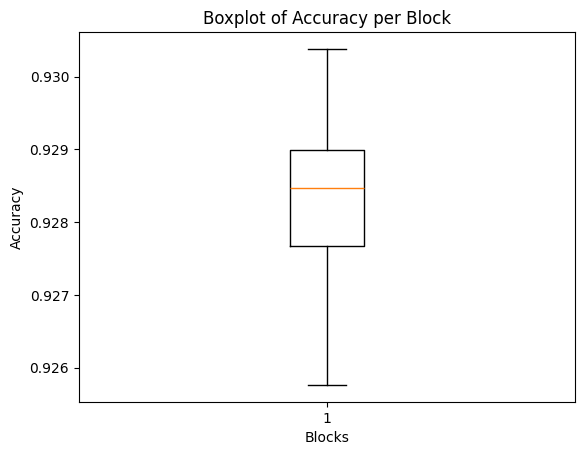

In [9]:
import matplotlib.pyplot as plt
plt.boxplot(all_ac)
plt.xlabel('Blocks')
plt.ylabel('Accuracy')
plt.title('Boxplot of Accuracy per Block')
plt.show()

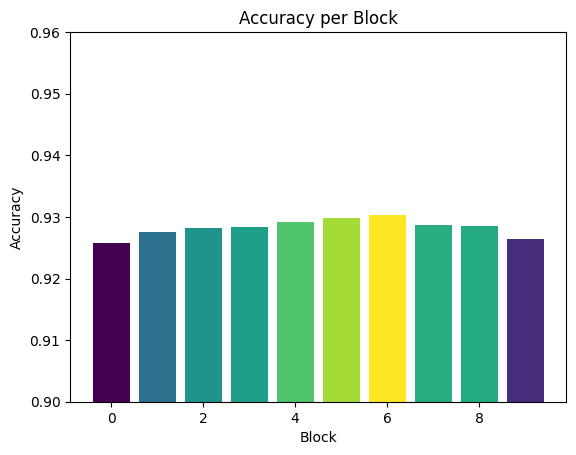

In [10]:
colors = plt.cm.viridis((np.array(all_ac) - min(all_ac)) / (max(all_ac) - min(all_ac)))
plt.bar(range(num_blocks_cv), all_ac, color=colors)
plt.xlabel('Block')
plt.ylabel('Accuracy')
plt.title('Accuracy per Block')
plt.ylim(0.90, 0.96)
plt.show()


# Memoria parte 1

In [11]:
def ej1_train(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    costs = []
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        costs.append(loss)
    return w, b, costs

Learning rates: 100%|██████████| 7/7 [16:21<00:00, 140.20s/it]                  


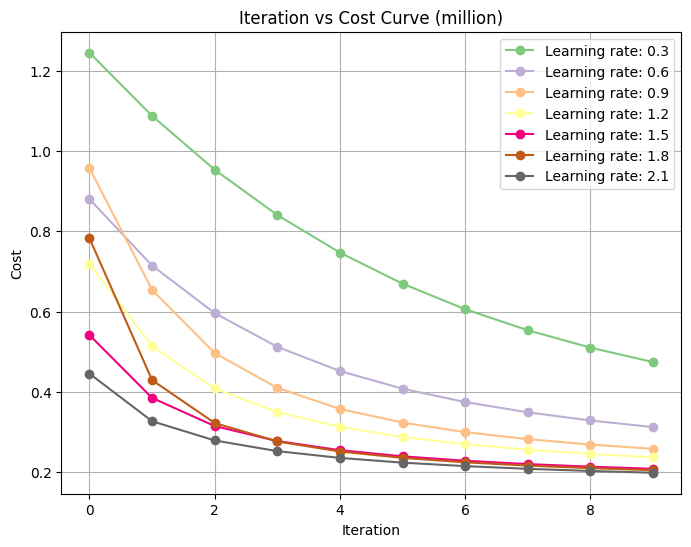

In [12]:
n = readFile(file_path)

normalizado = normalize(n)
total_costs=[]
learning_rates=[0.3,0.6,0.9,1.2,1.5,1.8,2.1]

colors = plt.cm.Accent((np.array(learning_rates) - min(learning_rates)) / (max(learning_rates) - min(learning_rates)))
lambda_reg=0
plt.figure(figsize=(8, 6))
for learning_rate in tqdm(learning_rates, desc=f"Learning rates"):
    w,b,costs=ej1_train(normalizado,10,learning_rate,0)
    total_costs.append(costs)

    plt.plot(costs, marker='o', linestyle='-',color=colors[learning_rates.index(learning_rate)],label=f"Learning rate: {learning_rate}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve (million)")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_learning_rate_million.png")  # Guardar imagen
plt.show()

Lambdas:   0%|          | 0/7 [00:00<?, ?it/s]                                  

0


Lambdas:  14%|█▍        | 1/7 [02:19<13:56, 139.45s/it]                         

0.1


Lambdas:  29%|██▊       | 2/7 [04:40<11:41, 140.30s/it]                         

0.2


Lambdas:  43%|████▎     | 3/7 [06:59<09:18, 139.61s/it]                         

0.3


Lambdas:  57%|█████▋    | 4/7 [09:17<06:57, 139.17s/it]                         

0.4


Lambdas:  71%|███████▏  | 5/7 [11:39<04:40, 140.04s/it]                         

0.5


Lambdas:  86%|████████▌ | 6/7 [13:58<02:19, 139.79s/it]                         

0.6


Lambdas: 100%|██████████| 7/7 [16:19<00:00, 139.96s/it]                         


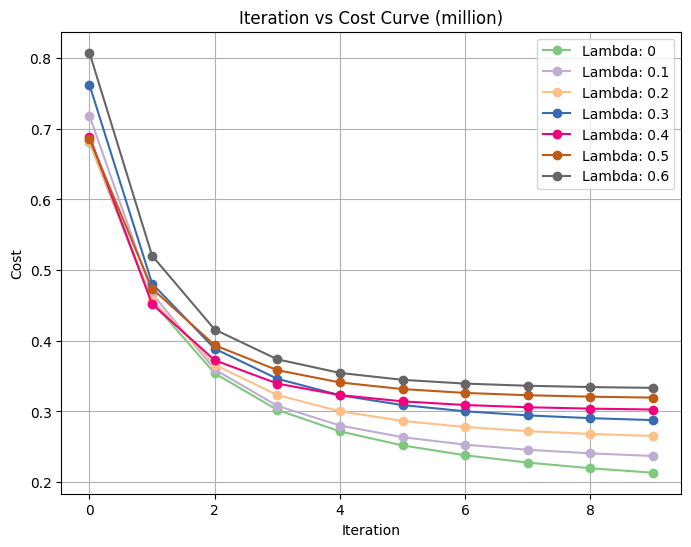

In [13]:
n = readFile(file_path)

normalizado = normalize(n)
lambdas=[0,0.1,0.2,0.3,0.4,0.5,0.6]

colors = plt.cm.Accent((np.array(lambdas) - min(lambdas)) / (max(lambdas) - min(lambdas)))
plt.figure(figsize=(8, 6))
for lamb in tqdm(lambdas, desc=f"Lambdas"):
    print(lamb)
    w,b,costs=ej1_train(normalizado,10,1.5,lamb)

    plt.plot(costs, marker='o', linestyle='-',color=colors[lambdas.index(lamb)],label=f"Lambda: {lamb}")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Iteration vs Cost Curve (million)")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_1_cost_curve_lambda_million.png")  # Guardar imagen
plt.show()

## Memoria Parte 2

Ejecutando pruebas:   0%|          | 0/24 [00:00<?, ?it/s]

Workers: 1, Particiones: 1


Ejecutando pruebas:   4%|▍         | 1/24 [05:06<1:57:33, 306.67s/it]           

Workers: 2, Particiones: 2


Ejecutando pruebas:   8%|▊         | 2/24 [07:50<1:21:39, 222.70s/it]           

Workers: 3, Particiones: 3


Ejecutando pruebas:  12%|█▎        | 3/24 [09:47<1:01:04, 174.52s/it]           

Workers: 4, Particiones: 4


Ejecutando pruebas:  17%|█▋        | 4/24 [11:20<47:26, 142.31s/it]             

Workers: 5, Particiones: 5


Ejecutando pruebas:  21%|██        | 5/24 [12:41<37:59, 120.00s/it]             

Workers: 6, Particiones: 6


Ejecutando pruebas:  25%|██▌       | 6/24 [13:56<31:29, 104.96s/it]             

Workers: 7, Particiones: 7


Ejecutando pruebas:  29%|██▉       | 7/24 [15:08<26:38, 94.06s/it]              

Workers: 8, Particiones: 8


Ejecutando pruebas:  33%|███▎      | 8/24 [16:15<22:45, 85.34s/it]              

Workers: 9, Particiones: 9


Ejecutando pruebas:  38%|███▊      | 9/24 [17:16<19:27, 77.83s/it]              

Workers: 10, Particiones: 10


Ejecutando pruebas:  42%|████▏     | 10/24 [18:15<16:46, 71.89s/it]             

Workers: 11, Particiones: 11


Ejecutando pruebas:  46%|████▌     | 11/24 [19:11<14:33, 67.18s/it]             

Workers: 12, Particiones: 12


Ejecutando pruebas:  50%|█████     | 12/24 [20:04<12:35, 62.96s/it]             

Workers: 13, Particiones: 13


Ejecutando pruebas:  54%|█████▍    | 13/24 [21:05<11:24, 62.23s/it]             

Workers: 14, Particiones: 14


Ejecutando pruebas:  58%|█████▊    | 14/24 [22:05<10:16, 61.68s/it]             

Workers: 15, Particiones: 15


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Workers: 16, Particiones: 16


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Workers: 17, Particiones: 17


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Workers: 18, Particiones: 18


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: Runtim

Workers: 19, Particiones: 19


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34

Workers: 20, Particiones: 20


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: Ru

Workers: 30, Particiones: 30


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning

Workers: 40, Particiones: 40


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Workers: 50, Particiones: 50


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Workers: 100, Particiones: 100


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: Ru

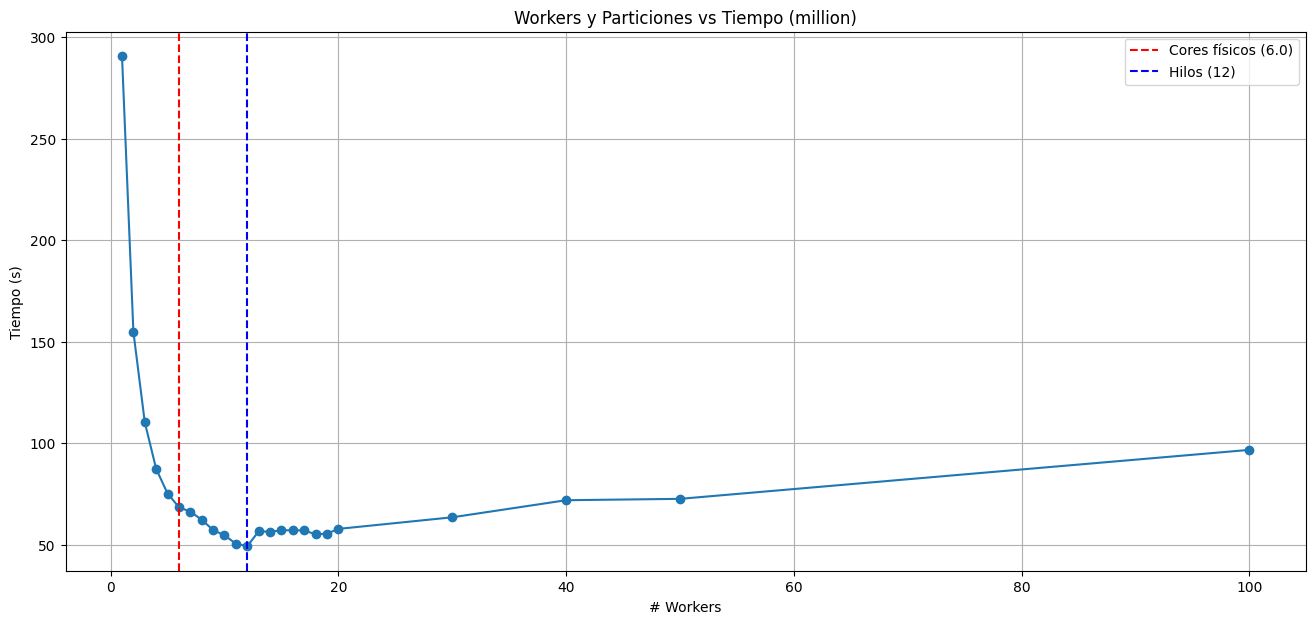

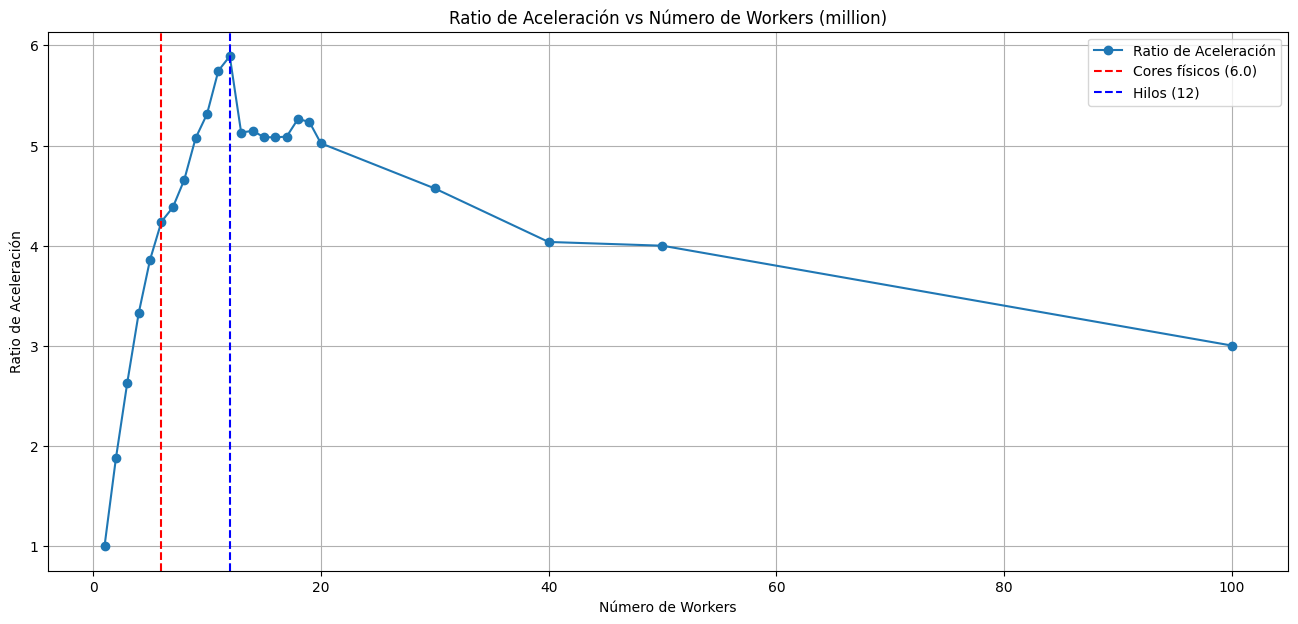

Tiempo de ejecución 33.565819052855176 minutos


In [14]:
inicial_inicial = time.time()
# Número de workers y particiones a probar
workers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 100]

# Obtener número de cores físicos y lógicos
num_hilos = os.cpu_count()  # Total de hilos (CPU lógicos)
num_cores = num_hilos / 2  # Cores físicos, asumo la mitad de hilos

try:
    sc.stop()
except:
    pass

plt.figure(figsize=(16, 7))
totals_por_workers = {}  # Almacenar tiempos por número de particiones

for worker in tqdm(workers, desc="Ejecutando pruebas"):
    p = worker  # Particiones igual a número de workers
    print(f"Workers: {worker}, Particiones: {p}")

    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    n = readFile(file_path)   
    normalizado = normalize(n)
    normalizado = normalizado.repartition(p)

    inicio = time.time()
    w, b, costs = ej1_train(normalizado, 10, 1.5, p)  # Se cambia el número de particiones aquí
    fin = time.time()

    sc.stop()
    totals_por_workers[p] = fin - inicio  # Guardamos los tiempos de ejecución

# Graficar
plt.plot(totals_por_workers.keys(), totals_por_workers.values(), marker='o', linestyle='-')

# Configurar la gráfica
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("# Workers")
plt.ylabel("Tiempo (s)")
plt.title("Workers y Particiones vs Tiempo (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_time_workers_million.png")
plt.show()

# ==========================
# Cálculo del Ratio de Aceleración
# ==========================

plt.figure(figsize=(16, 7))

tiempo_worker_1 = totals_por_workers[1]  # Tiempo con 1 worker
ratios = {worker: tiempo_worker_1 / totals_por_workers[worker] for worker in workers}  # Calcular el ratio de aceleración 

# Graficar el ratio de aceleración
plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', label="Ratio de Aceleración")

# Marcar líneas verticales para cores físicos y hilos
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_speed_up_million.png")
plt.show()

final_final = time.time()
print(f"Tiempo de ejecución {(final_final - inicial_inicial)/60} minutos")


## Memoria Parte 3

### Tiempo normal

In [15]:
sc = SparkContext("local[*]", "Name of the Program")

In [16]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)

w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
normal_time = end_time - start_time
print(normal_time)

Iteration: 0, Loss: [0.63506163]


Iteration: 1, Loss: [0.44383332]


Iteration: 2, Loss: [0.35643042]


Iteration: 3, Loss: [0.30891081]


Iteration: 4, Loss: [0.27956195]


Iteration: 5, Loss: [0.25974008]


Iteration: 6, Loss: [0.24547273]


Iteration: 7, Loss: [0.23470756]


Iteration: 8, Loss: [0.22628558]


Iteration: 9, Loss: [0.21950607]


Final accuracy: 0.924897
147.7630157470703


### Cacheamos el normalizado

In [17]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_normalizado = end_time - start_time
print(cached_normalizado)

Iteration: 0, Loss: [0.58153055]


Iteration: 1, Loss: [0.39531592]


Iteration: 2, Loss: [0.32360884]


Iteration: 3, Loss: [0.28653919]


Iteration: 4, Loss: [0.26355595]


Iteration: 5, Loss: [0.24770687]


Iteration: 6, Loss: [0.23602316]


Iteration: 7, Loss: [0.22701139]


Iteration: 8, Loss: [0.21982924]


Iteration: 9, Loss: [0.21396093]


Final accuracy: 0.929001
62.88840293884277


### Cachemos gradientes

In [18]:
def train_cached_grad(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        gradients.cache()
        _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [19]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
# normalizado.cache()
# _ = normalizado.count()
w,b=train_cached_grad(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_gradients = end_time - start_time
print(cached_gradients)

Iteration: 0, Loss: [0.57130112]


Iteration: 1, Loss: [0.36921339]


Iteration: 2, Loss: [0.29898215]


Iteration: 3, Loss: [0.26533532]


Iteration: 4, Loss: [0.24541123]


Iteration: 5, Loss: [0.23208481]


Iteration: 6, Loss: [0.22245746]


Iteration: 7, Loss: [0.21512669]


Iteration: 8, Loss: [0.20932858]


Iteration: 9, Loss: [0.20460975]


Final accuracy: 0.932671
145.2281138896942


### Cachemos gradients y normalizado

In [20]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_grad(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_gradients_normalizado = end_time - start_time
print(cached_gradients_normalizado)

Iteration: 0, Loss: [0.66690879]


Iteration: 1, Loss: [0.44596216]


Iteration: 2, Loss: [0.34826655]


Iteration: 3, Loss: [0.29862739]


Iteration: 4, Loss: [0.26964755]


Iteration: 5, Loss: [0.25080402]


Iteration: 6, Loss: [0.23756777]


Iteration: 7, Loss: [0.22773478]


Iteration: 8, Loss: [0.22011777]


Iteration: 9, Loss: [0.21402422]


Final accuracy: 0.926909
79.88111543655396


### Cacheamos el predict en el train

In [21]:
def train_cached_pred(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        predictions_targets_inputs.cache()
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        # gradients.cache()
        # _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [22]:

n = readFile(file_path)
start_time = time.time()
# normalizado = normalize(n)
# normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict = end_time - start_time
print(cached_predict)

Iteration: 0, Loss: [1.09250765]


Iteration: 1, Loss: [0.55269602]


Iteration: 2, Loss: [0.37660186]


Iteration: 3, Loss: [0.30862354]


Iteration: 4, Loss: [0.27357928]


Iteration: 5, Loss: [0.2521053]


Iteration: 6, Loss: [0.23753017]


Iteration: 7, Loss: [0.22695437]


Iteration: 8, Loss: [0.21890987]


Iteration: 9, Loss: [0.21257143]


Final accuracy: 0.929415
61.50159764289856


### Chacheamos predict y grads

In [23]:
def train_cached(RDD_Xy, iterations, learning_rate, lambda_reg):
    w = np.random.rand(11)
    b = np.random.rand(1)
    
    for iteration in range(iterations):
        predictions_targets_inputs = RDD_Xy.map(lambda x: (predict_train(w, b, x[0]), x[1], x[0]))
        predictions_targets_inputs.cache()
        count = predictions_targets_inputs.count()
        
        gradients = predictions_targets_inputs.map(lambda x: ((x[0] - x[1]) * np.array(x[2]), x[0] - x[1]))
        gradients.cache()
        _ = gradients.count()
        gradient_w = gradients.map(lambda x: x[0]).reduce(lambda x, y: x + y) / count + (lambda_reg * w) / len(w)
        gradient_b = gradients.map(lambda x: x[1]).reduce(lambda x, y: x + y) / count
        
        w -= learning_rate * gradient_w
        b -= learning_rate * gradient_b
        
        loss = calculate_loss_function(predictions_targets_inputs, lambda_reg, w)
        print(f"Iteration: {iteration}, Loss: {loss}")
    
    return w, b

In [24]:

n = readFile(file_path)
start_time = time.time()
# normalizado = normalize(n)
# normalizado.cache()
_ = normalizado.count()
w,b=train_cached(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict_grad = end_time - start_time
print(cached_predict_grad)

Iteration: 0, Loss: [1.44890696]


Iteration: 1, Loss: [0.71654422]


Iteration: 2, Loss: [0.46497218]


Iteration: 3, Loss: [0.36138884]


Iteration: 4, Loss: [0.30955107]


Iteration: 5, Loss: [0.27918229]


Iteration: 6, Loss: [0.25922683]


Iteration: 7, Loss: [0.24504292]


Iteration: 8, Loss: [0.23439117]


Iteration: 9, Loss: [0.22606451]


Final accuracy: 0.926601
78.0745313167572


### Cacheamos predict y normalizado

In [25]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_predict_norm = end_time - start_time
print(cached_predict_norm)

Iteration: 0, Loss: [1.7318604]


Iteration: 1, Loss: [0.82210034]


Iteration: 2, Loss: [0.47607185]


Iteration: 3, Loss: [0.3546625]


Iteration: 4, Loss: [0.3003336]


Iteration: 5, Loss: [0.27021599]


Iteration: 6, Loss: [0.25104316]


Iteration: 7, Loss: [0.23769242]


Iteration: 8, Loss: [0.22780806]


Iteration: 9, Loss: [0.22016014]


Final accuracy: 0.928515
65.6881594657898


### Combinamos los tres

In [26]:

n = readFile(file_path)
start_time = time.time()
normalizado = normalize(n)
normalizado.cache()
_ = normalizado.count()
w,b=train_cached_pred(normalizado,10,1.5,0)

acc=accuracy(w,b,normalizado)
print(f"Final accuracy: {acc}")
end_time = time.time()
cached_all = end_time - start_time
print(cached_all)

Iteration: 0, Loss: [1.27902575]


Iteration: 1, Loss: [0.66935039]


Iteration: 2, Loss: [0.44025351]


Iteration: 3, Loss: [0.34017653]


Iteration: 4, Loss: [0.29033426]


Iteration: 5, Loss: [0.26192274]


Iteration: 6, Loss: [0.24382466]


Iteration: 7, Loss: [0.2313173]


Iteration: 8, Loss: [0.22214143]


Iteration: 9, Loss: [0.21510062]


Final accuracy: 0.929746
67.4014024734497


### Plot

[147.7630157470703, 62.88840293884277, 145.2281138896942, 79.88111543655396, 61.50159764289856, 78.0745313167572, 65.6881594657898, 67.4014024734497]


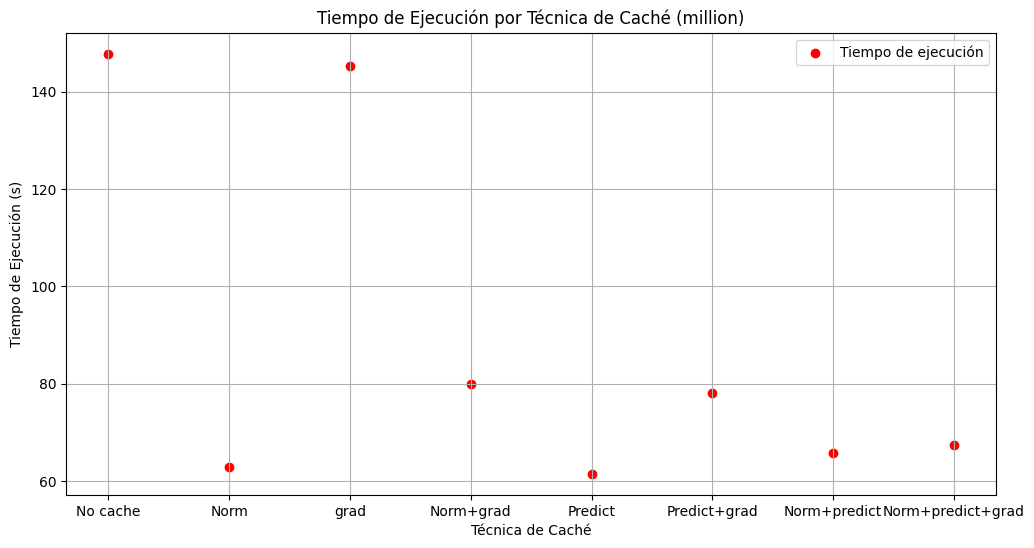

In [27]:
tecnicas_cache = ["No cache", "Norm", "grad", "Norm+grad", "Predict", 'Predict+grad', 'Norm+predict','Norm+predict+grad']
tiempos_cache = [normal_time, cached_normalizado, cached_gradients, cached_gradients_normalizado, cached_predict, cached_predict_grad, cached_predict_norm, cached_all]  # Ejemplo de tiempos en segundos
print(tiempos_cache)
plt.figure(figsize=(12, 6))
plt.scatter(tecnicas_cache, tiempos_cache, color='r', label='Tiempo de ejecución')
plt.xlabel("Técnica de Caché")
plt.ylabel("Tiempo de Ejecución (s)")
plt.title("Tiempo de Ejecución por Técnica de Caché (million)")
plt.legend()
plt.grid()
plt.savefig(f"results/Ej_3a_cached_million.png") 

plt.show()


## Memoria Parte 3B

Ejecutando pruebas:   0%|          | 0/24 [00:00<?, ?it/s]

Workers: 1, Particiones: 1


Iteration: 0, Loss: [1.16262876]


Iteration: 1, Loss: [0.63124153]


Iteration: 2, Loss: [0.46670679]


Iteration: 3, Loss: [0.4119985]


Iteration: 4, Loss: [0.39160198]


Iteration: 5, Loss: [0.38317475]


Iteration: 6, Loss: [0.37943068]


Iteration: 7, Loss: [0.37766283]


Iteration: 8, Loss: [0.37677467]


Iteration: 9, Loss: [0.37629779]


Ejecutando pruebas:   4%|▍         | 1/24 [05:17<2:01:43, 317.55s/it]

Workers: 2, Particiones: 2


Iteration: 0, Loss: [1.17532729]


Iteration: 1, Loss: [0.54512145]


Iteration: 2, Loss: [0.47182232]


Iteration: 3, Loss: [0.45283831]


Iteration: 4, Loss: [0.44623457]


Iteration: 5, Loss: [0.44359621]


Iteration: 6, Loss: [0.44244282]


Iteration: 7, Loss: [0.44190636]


Iteration: 8, Loss: [0.44164618]


Iteration: 9, Loss: [0.44151625]


Ejecutando pruebas:   8%|▊         | 2/24 [08:06<1:24:17, 229.90s/it]

Workers: 3, Particiones: 3


Iteration: 0, Loss: [1.73062189]


Iteration: 1, Loss: [0.68078473]


Iteration: 2, Loss: [0.51552005]


Iteration: 3, Loss: [0.4930491]


Iteration: 4, Loss: [0.4864479]


Iteration: 5, Loss: [0.48366597]


Iteration: 6, Loss: [0.48237581]


Iteration: 7, Loss: [0.48175312]


Iteration: 8, Loss: [0.4814435]


Iteration: 9, Loss: [0.48128515]


Ejecutando pruebas:  12%|█▎        | 3/24 [10:04<1:02:40, 179.06s/it]

Workers: 4, Particiones: 4


Iteration: 0, Loss: [1.82261626]


Iteration: 1, Loss: [0.52577133]


Iteration: 2, Loss: [0.51581641]


Iteration: 3, Loss: [0.51088126]


Iteration: 4, Loss: [0.50959222]


Iteration: 5, Loss: [0.50911686]


Iteration: 6, Loss: [0.50893288]


Iteration: 7, Loss: [0.50885222]


Iteration: 8, Loss: [0.50881386]


Iteration: 9, Loss: [0.50879423]


Ejecutando pruebas:  17%|█▋        | 4/24 [11:40<48:41, 146.10s/it]  

Workers: 5, Particiones: 5


Iteration: 0, Loss: [1.33700324]


Iteration: 1, Loss: [0.50248923]


Iteration: 2, Loss: [0.54728025]


Iteration: 3, Loss: [0.52935952]


Iteration: 4, Loss: [0.53160465]


Iteration: 5, Loss: [0.52993154]


Iteration: 6, Loss: [0.52987682]


Iteration: 7, Loss: [0.52965477]


Iteration: 8, Loss: [0.52959739]


Iteration: 9, Loss: [0.52955484]


Ejecutando pruebas:  21%|██        | 5/24 [13:05<39:22, 124.32s/it]

Workers: 6, Particiones: 6


Iteration: 0, Loss: [1.46543423]


Iteration: 1, Loss: [0.48052994]


Iteration: 2, Loss: [0.61459504]


Iteration: 3, Loss: [0.534926]


Iteration: 4, Loss: [0.55844425]


Iteration: 5, Loss: [0.54392113]


Iteration: 6, Loss: [0.54822265]


Iteration: 7, Loss: [0.54551037]


Iteration: 8, Loss: [0.54626536]


Iteration: 9, Loss: [0.54575862]


Ejecutando pruebas:  25%|██▌       | 6/24 [14:23<32:28, 108.27s/it]

Workers: 7, Particiones: 7


Iteration: 0, Loss: [2.23704311]


Iteration: 1, Loss: [0.45248507]


Iteration: 2, Loss: [0.743352]


Iteration: 3, Loss: [0.51157988]


Iteration: 4, Loss: [0.60913328]


Iteration: 5, Loss: [0.53921175]


Iteration: 6, Loss: [0.57459358]


Iteration: 7, Loss: [0.55156801]


Iteration: 8, Loss: [0.56404209]


Iteration: 9, Loss: [0.55634732]


Ejecutando pruebas:  29%|██▉       | 7/24 [15:39<27:45, 97.95s/it] 

Workers: 8, Particiones: 8


Iteration: 0, Loss: [1.68477987]


Iteration: 1, Loss: [0.45312595]


Iteration: 2, Loss: [0.78322692]


Iteration: 3, Loss: [0.47883372]


Iteration: 4, Loss: [0.66185559]


Iteration: 5, Loss: [0.51727523]


Iteration: 6, Loss: [0.61478011]


Iteration: 7, Loss: [0.5408628]


Iteration: 8, Loss: [0.59282613]


Iteration: 9, Loss: [0.55414397]


Ejecutando pruebas:  33%|███▎      | 8/24 [16:47<23:34, 88.40s/it]

Workers: 9, Particiones: 9


Iteration: 0, Loss: [1.86855508]


Iteration: 1, Loss: [0.64194972]


Iteration: 2, Loss: [0.8544711]


Iteration: 3, Loss: [0.50838944]


Iteration: 4, Loss: [0.72286264]


Iteration: 5, Loss: [0.50794284]


Iteration: 6, Loss: [0.67511872]


Iteration: 7, Loss: [0.51962436]


Iteration: 8, Loss: [0.64801385]


Iteration: 9, Loss: [0.53131762]


Ejecutando pruebas:  38%|███▊      | 9/24 [17:51<20:08, 80.57s/it]

Workers: 10, Particiones: 10


Iteration: 0, Loss: [2.64004571]


Iteration: 1, Loss: [0.828569]


Iteration: 2, Loss: [1.33707128]


Iteration: 3, Loss: [0.53566328]


Iteration: 4, Loss: [1.08714352]


Iteration: 5, Loss: [0.47381185]


Iteration: 6, Loss: [1.01161262]


Iteration: 7, Loss: [0.45511336]


Iteration: 8, Loss: [0.97990072]


Iteration: 9, Loss: [0.44755229]


Ejecutando pruebas:  42%|████▏     | 10/24 [18:52<17:24, 74.59s/it]

Workers: 11, Particiones: 11


Iteration: 0, Loss: [3.05209619]


Iteration: 1, Loss: [1.1548697]


Iteration: 2, Loss: [2.14745542]


Iteration: 3, Loss: [0.77040346]


Iteration: 4, Loss: [2.03361814]


Iteration: 5, Loss: [0.66974685]


Iteration: 6, Loss: [2.10702949]


Iteration: 7, Loss: [0.64778235]


Iteration: 8, Loss: [2.21813699]


Iteration: 9, Loss: [0.65031656]


Ejecutando pruebas:  46%|████▌     | 11/24 [19:50<15:05, 69.66s/it]

Workers: 12, Particiones: 12


Iteration: 0, Loss: [3.0052615]


Iteration: 1, Loss: [1.44673467]


Iteration: 2, Loss: [2.68754985]


Iteration: 3, Loss: [1.143304]


Iteration: 4, Loss: [3.04236809]


Iteration: 5, Loss: [1.17822523]


Iteration: 6, Loss: [3.68160755]


Iteration: 7, Loss: [1.35543274]


Iteration: 8, Loss: [4.32168829]


Iteration: 9, Loss: [1.54867226]


Ejecutando pruebas:  50%|█████     | 12/24 [20:46<13:04, 65.35s/it]

Workers: 13, Particiones: 13


Iteration: 0, Loss: [4.28223506]


Iteration: 1, Loss: [2.85207172]


Iteration: 2, Loss: [4.72994375]


Iteration: 3, Loss: [2.9536156]


Iteration: 4, Loss: [5.63638385]


Iteration: 5, Loss: [3.31811083]


Iteration: 6, Loss: [6.9185808]


Iteration: 7, Loss: [3.88746168]


Iteration: 8, Loss: [8.38315506]


Iteration: 9, Loss: [4.55366567]


Ejecutando pruebas:  54%|█████▍    | 13/24 [21:48<11:49, 64.50s/it]

Workers: 14, Particiones: 14


Iteration: 0, Loss: [3.65441158]


Iteration: 1, Loss: [4.29323231]


Iteration: 2, Loss: [5.48578127]


Iteration: 3, Loss: [6.10734451]


Iteration: 4, Loss: [8.00767262]


Iteration: 5, Loss: [8.33448601]


Iteration: 6, Loss: [11.0638636]


Iteration: 7, Loss: [10.83687682]


Iteration: 8, Loss: [14.52603103]


Iteration: 9, Loss: [13.52434847]


Ejecutando pruebas:  58%|█████▊    | 14/24 [22:51<10:40, 64.00s/it]

Workers: 15, Particiones: 15


Iteration: 0, Loss: [7.21189416]


Iteration: 1, Loss: [8.87103146]


Iteration: 2, Loss: [15.52346972]


Iteration: 3, Loss: [18.09300142]


Iteration: 4, Loss: [29.63110207]


Iteration: 5, Loss: [33.23534449]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log


Iteration: 6, Loss: [inf]


Iteration: 7, Loss: [56.03032912]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Iteration: 8, Loss: [inf]


Iteration: 9, Loss: [88.54565307]


Ejecutando pruebas:  62%|██████▎   | 15/24 [23:54<09:33, 63.75s/it]

Workers: 16, Particiones: 16


Iteration: 0, Loss: [10.85927635]


Iteration: 1, Loss: [15.42298625]


Iteration: 2, Loss: [32.75893792]


Iteration: 3, Loss: [45.49706255]


Iteration: 4, Loss: [84.50429395]


Iteration: 5, Loss: [116.33388172]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Iteration: 6, Loss: [inf]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: Ru

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  67%|██████▋   | 16/24 [24:57<08:28, 63.53s/it]

Workers: 17, Particiones: 17


Iteration: 0, Loss: [9.97738156]


Iteration: 1, Loss: [18.0131062]


Iteration: 2, Loss: [42.56647058]


Iteration: 3, Loss: [75.1658397]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Iteration: 4, Loss: [inf]


Iteration: 5, Loss: [271.22586675]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  71%|███████   | 17/24 [26:00<07:23, 63.33s/it]

Workers: 18, Particiones: 18


Iteration: 0, Loss: [10.09994884]


Iteration: 1, Loss: [25.02727705]


Iteration: 2, Loss: [60.47783831]


Iteration: 3, Loss: [137.73688083]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWar

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  75%|███████▌  | 18/24 [27:04<06:19, 63.33s/it]

Workers: 19, Particiones: 19


Iteration: 0, Loss: [14.24257477]


Iteration: 1, Loss: [36.85949096]


Iteration: 2, Loss: [112.19457074]


Iteration: 3, Loss: [286.14362953]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: Runtim

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  79%|███████▉  | 19/24 [28:08<05:18, 63.80s/it]

Workers: 20, Particiones: 20


Iteration: 0, Loss: [18.74473533]


Iteration: 1, Loss: [56.88155547]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Iteration: 2, Loss: [inf]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: di

Iteration: 3, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: Ru

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp]
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarnin

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp]
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Run

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  83%|████████▎ | 20/24 [29:14<04:16, 64.21s/it]

Workers: 30, Particiones: 30


Iteration: 0, Loss: [66.64815231]


Iteration: 1, Loss: [646.44647836]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 2, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 3, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp]
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Run

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  88%|████████▊ | 21/24 [30:23<03:17, 65.91s/it]

Workers: 40, Particiones: 40


Iteration: 0, Loss: [125.84260999]


Iteration: 1, Loss: [2527.44170432]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 2, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp]
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Run

Iteration: 3, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp]
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Run

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  92%|█████████▏| 22/24 [31:39<02:17, 68.87s/it]

Workers: 50, Particiones: 50


Iteration: 0, Loss: [175.69999273]


Iteration: 1, Loss: [6007.02317987]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 2, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp]
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Run

Iteration: 3, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 9, Loss: [nan]


Ejecutando pruebas:  96%|█████████▌| 23/24 [32:58<01:11, 71.83s/it]

Workers: 100, Particiones: 100


Iteration: 0, Loss: [1068.34125946]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: Ru

Iteration: 1, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: invalid value encountered in multiply
/tmp/ipykernel_98/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_98/4294485523.py:34

Iteration: 2, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 3, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 4, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 5, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 6, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 7, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 8, Loss: [nan]


/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: RuntimeWarning: overflow encountered in exp
/tmp/ipykernel_98/4294485523.py:53: Runt

Iteration: 9, Loss: [nan]


Ejecutando pruebas: 100%|██████████| 24/24 [34:45<00:00, 86.88s/it]


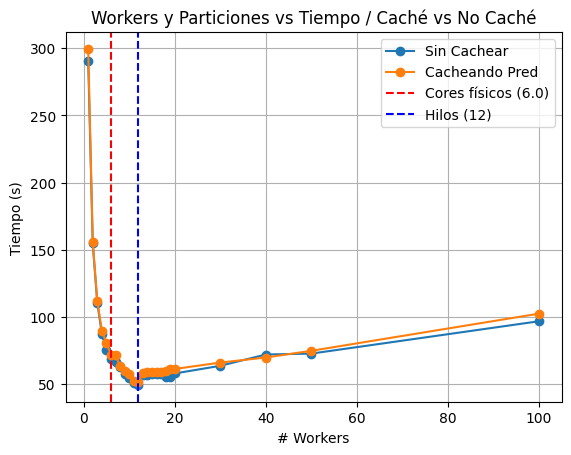

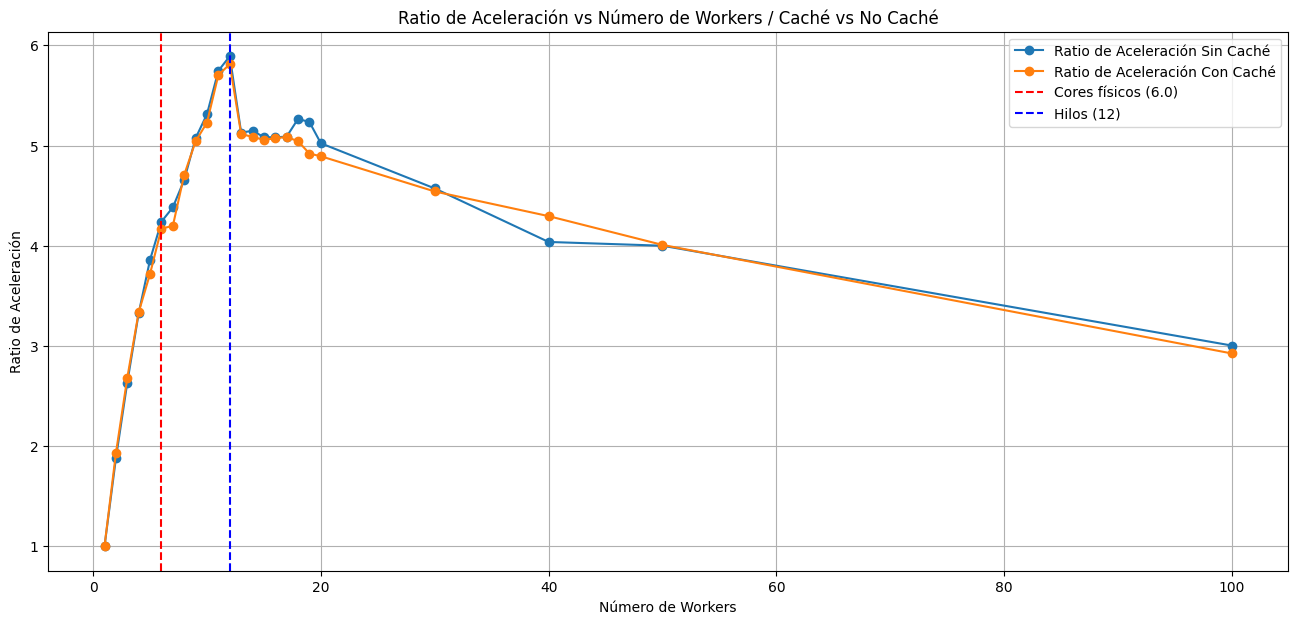

Tiempo de ejecución 34.76406544446945 minutos


In [28]:
inicial_inicial = time.time()
# Número de workers y particiones a probar
workers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40, 50, 100]

# Obtener número de cores físicos y lógicos
num_hilos = os.cpu_count()  # Total de hilos (CPU lógicos)
num_cores = num_hilos / 2  # Cores físicos, asumo la mitad de hilos

try:
    sc.stop()
except:
    pass

# Graficar en la misma figura
plt.plot(totals_por_workers.keys(), totals_por_workers.values(), marker='o', linestyle='-', label=f"Sin Cachear")

# Cache predict
totals_por_workers_c = {}  # Almacenar tiempos por número de particiones

for worker in tqdm(workers, desc="Ejecutando pruebas"):
    p = worker  # Particiones igual a número de workers
    print(f"Workers: {worker}, Particiones: {p}")

    sc = SparkContext(f"local[{worker}]", "Name of the Program")
    n = readFile(file_path)   
    normalizado = normalize(n)
    normalizado = normalizado.repartition(p)

    inicio = time.time()
    w, b = train_cached_pred(normalizado, 10, 1.5, p)  # Se cambia el número de particiones aquí
    fin = time.time()

    sc.stop()
    totals_por_workers_c[p] = fin - inicio  # Guardamos los tiempos de ejecución

# Graficar en la misma figura
plt.plot(totals_por_workers_c.keys(), totals_por_workers_c.values(), marker='o', linestyle='-', label=f"Cacheando Pred")

# Configurar la gráfica
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("# Workers")
plt.ylabel("Tiempo (s)")
plt.title("Workers y Particiones vs Tiempo / Caché vs No Caché")
plt.legend()
plt.grid()
plt.savefig("results/Ej_3b_time_workers_cache_million.png")
plt.show()

# ==========================
# Cálculo del Ratio de Aceleración
# ==========================

plt.figure(figsize=(16, 7))

tiempo_worker_1 = totals_por_workers[1]  # Tiempo con 1 worker
ratios = {worker: tiempo_worker_1 / totals_por_workers[worker] for worker in workers}  # Calcular el ratio de aceleración 

tiempo_worker_1_c = totals_por_workers_c[1]  # Tiempo con 1 worker
ratios_c = {worker: tiempo_worker_1_c / totals_por_workers_c[worker] for worker in workers}  # Calcular el ratio de aceleración 

# Graficar el ratio de aceleración
plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', label="Ratio de Aceleración Sin Caché")
plt.plot(list(ratios_c.keys()), list(ratios_c.values()), marker='o', linestyle='-', label="Ratio de Aceleración Con Caché")

# Marcar líneas verticales para cores físicos y hilos
plt.axvline(x=num_cores, color='r', linestyle='--', label=f'Cores físicos ({num_cores})')
plt.axvline(x=num_hilos, color='b', linestyle='--', label=f'Hilos ({num_hilos})')

plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers / Caché vs No Caché")
plt.legend()
plt.grid()
plt.savefig("results/Ej_3b_speed_up_cache_million.png")
plt.show()

final_final = time.time()
print(f"Tiempo de ejecución {(final_final - inicial_inicial)/60} minutos")


## Memoria Parte 4

Partitions:   0%|          | 0/8 [00:00<?, ?it/s]

1


Partitions:  12%|█▎        | 1/8 [04:48<33:42, 288.92s/it]                      

2


Partitions:  25%|██▌       | 2/8 [07:26<21:09, 211.61s/it]                      

3


Partitions:  38%|███▊      | 3/8 [09:18<13:51, 166.31s/it]                      

4


Partitions:  50%|█████     | 4/8 [10:49<09:06, 136.59s/it]                      

5


Partitions:  62%|██████▎   | 5/8 [12:58<06:40, 133.61s/it]                      

6


Partitions:  75%|███████▌  | 6/8 [14:49<04:12, 126.08s/it]                      

7


Partitions:  88%|████████▊ | 7/8 [16:31<01:58, 118.25s/it]                      

8


Partitions: 100%|██████████| 8/8 [18:07<00:00, 135.92s/it]                      


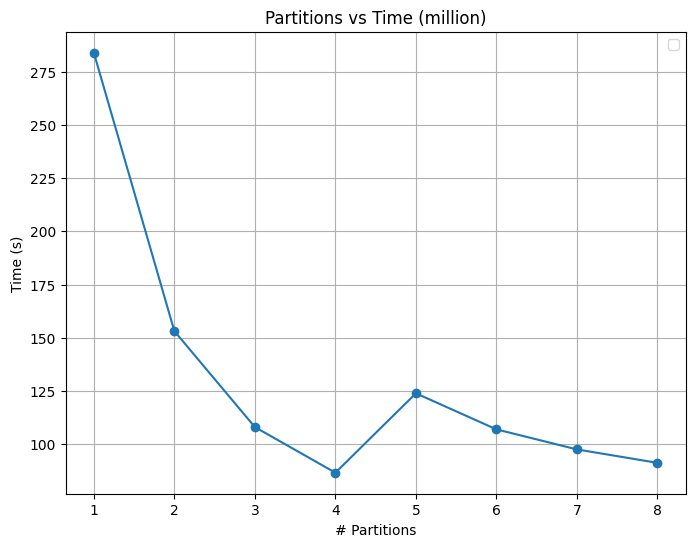

In [29]:
partitions=range(1,9)

try:
    sc.stop()
except:
    pass
sc = SparkContext(f"local[{4}]", "Name of the Program")
totals=[]
plt.figure(figsize=(8, 6))
for partition in tqdm(partitions, desc=f"Partitions"):
    print(partition)
    n = readFile(file_path)   
    normalizado = normalize(n)
    normalizado=normalizado.repartition(partition)

    inicio=time.time()
    w,b,costs=ej1_train(normalizado,10,1.5,0)
    fin=time.time()
    totals.append(fin-inicio)

plt.plot(range(1, len(totals) + 1), totals, marker='o', linestyle='-')
plt.xlabel("# Partitions")
plt.ylabel("Time (s)")
plt.title("Partitions vs Time (million)")
plt.grid()
plt.legend()
plt.savefig(f"results/Ej_4_time_partitions_million.png") 
plt.show()

## Memoria - Anexo

Workers (particiones=2):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 2


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/01 19:42:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Workers (particiones=2):   7%|▋         | 1/14 [05:26<1:10:39, 326.10s/it]      

Workers: 2, Particiones: 2


Workers (particiones=2):  14%|█▍        | 2/14 [08:13<46:36, 233.01s/it]        

Workers: 3, Particiones: 2


Workers (particiones=2):  21%|██▏       | 3/14 [10:56<36:50, 200.97s/it]        

Workers: 4, Particiones: 2


Workers (particiones=2):  29%|██▊       | 4/14 [13:36<30:44, 184.50s/it]        

Workers: 5, Particiones: 2


Workers (particiones=2):  36%|███▌      | 5/14 [16:09<26:00, 173.34s/it]        

Workers: 6, Particiones: 2


Workers (particiones=2):  43%|████▎     | 6/14 [18:47<22:24, 168.10s/it]        

Workers: 7, Particiones: 2


Workers (particiones=2):  50%|█████     | 7/14 [21:27<19:18, 165.55s/it]        

Workers: 8, Particiones: 2


Workers (particiones=2):  57%|█████▋    | 8/14 [24:03<16:15, 162.55s/it]        

Workers: 9, Particiones: 2


Workers (particiones=2):  64%|██████▍   | 9/14 [26:37<13:18, 159.74s/it]        

Workers: 10, Particiones: 2


Workers (particiones=2):  71%|███████▏  | 10/14 [29:12<10:33, 158.26s/it]       

Workers: 15, Particiones: 2


Workers (particiones=2):  79%|███████▊  | 11/14 [31:46<07:51, 157.03s/it]       

Workers: 20, Particiones: 2


Workers (particiones=2):  86%|████████▌ | 12/14 [34:21<05:12, 156.49s/it]       

Workers: 30, Particiones: 2


Workers (particiones=2):  93%|█████████▎| 13/14 [36:56<02:35, 155.98s/it]       

Workers: 50, Particiones: 2


Workers (particiones=6):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 6


Workers (particiones=6):   7%|▋         | 1/14 [05:32<1:11:59, 332.26s/it]      

Workers: 2, Particiones: 6


Workers (particiones=6):  14%|█▍        | 2/14 [08:24<47:35, 237.98s/it]        

Workers: 3, Particiones: 6


Workers (particiones=6):  21%|██▏       | 3/14 [10:22<33:36, 183.27s/it]        

Workers: 4, Particiones: 6


Workers (particiones=6):  29%|██▊       | 4/14 [12:16<25:59, 155.92s/it]        

Workers: 5, Particiones: 6


Workers (particiones=6):  36%|███▌      | 5/14 [14:08<21:01, 140.20s/it]        

Workers: 6, Particiones: 6


Workers (particiones=6):  43%|████▎     | 6/14 [15:24<15:45, 118.17s/it]        

Workers: 7, Particiones: 6


Workers (particiones=6):  50%|█████     | 7/14 [16:38<12:06, 103.83s/it]        

Workers: 8, Particiones: 6


Workers (particiones=6):  57%|█████▋    | 8/14 [17:52<09:25, 94.33s/it]         

Workers: 9, Particiones: 6


Workers (particiones=6):  64%|██████▍   | 9/14 [19:04<07:17, 87.42s/it]         

Workers: 10, Particiones: 6


Workers (particiones=6):  71%|███████▏  | 10/14 [20:16<05:30, 82.67s/it]        

Workers: 15, Particiones: 6


Workers (particiones=6):  79%|███████▊  | 11/14 [21:28<03:58, 79.48s/it]        

Workers: 20, Particiones: 6


Workers (particiones=6):  86%|████████▌ | 12/14 [22:41<02:34, 77.29s/it]        

Workers: 30, Particiones: 6


Workers (particiones=6):  93%|█████████▎| 13/14 [23:54<01:15, 75.96s/it]        

Workers: 50, Particiones: 6


Workers (particiones=8):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 8


Workers (particiones=8):   7%|▋         | 1/14 [05:34<1:12:33, 334.89s/it]      

Workers: 2, Particiones: 8


Workers (particiones=8):  14%|█▍        | 2/14 [08:31<48:19, 241.62s/it]        

Workers: 3, Particiones: 8


Workers (particiones=8):  21%|██▏       | 3/14 [10:43<35:10, 191.87s/it]        

Workers: 4, Particiones: 8


Workers (particiones=8):  29%|██▊       | 4/14 [12:20<25:41, 154.12s/it]        

Workers: 5, Particiones: 8


Workers (particiones=8):  36%|███▌      | 5/14 [13:53<19:50, 132.31s/it]        

Workers: 6, Particiones: 8


Workers (particiones=8):  43%|████▎     | 6/14 [15:26<15:50, 118.86s/it]        

Workers: 7, Particiones: 8


Workers (particiones=8):  50%|█████     | 7/14 [17:01<12:57, 111.07s/it]        

Workers: 8, Particiones: 8


Workers (particiones=8):  57%|█████▋    | 8/14 [18:07<09:40, 96.74s/it]         

Workers: 9, Particiones: 8


Workers (particiones=8):  64%|██████▍   | 9/14 [19:12<07:14, 86.88s/it]         

Workers: 10, Particiones: 8


Workers (particiones=8):  71%|███████▏  | 10/14 [20:17<05:20, 80.13s/it]        

Workers: 15, Particiones: 8


Workers (particiones=8):  79%|███████▊  | 11/14 [21:23<03:46, 75.60s/it]        

Workers: 20, Particiones: 8


Workers (particiones=8):  86%|████████▌ | 12/14 [22:28<02:25, 72.62s/it]        

Workers: 30, Particiones: 8


Workers (particiones=8):  93%|█████████▎| 13/14 [23:34<01:10, 70.43s/it]        

Workers: 50, Particiones: 8


Workers (particiones=10):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 10


Workers (particiones=10):   7%|▋         | 1/14 [05:38<1:13:26, 338.97s/it]     

Workers: 2, Particiones: 10


Workers (particiones=10):  14%|█▍        | 2/14 [08:38<49:03, 245.33s/it]       

Workers: 3, Particiones: 10


Workers (particiones=10):  21%|██▏       | 3/14 [10:58<36:07, 197.08s/it]       

Workers: 4, Particiones: 10


Workers (particiones=10):  29%|██▊       | 4/14 [12:46<27:00, 162.07s/it]       

Workers: 5, Particiones: 10


Workers (particiones=10):  36%|███▌      | 5/14 [14:11<20:07, 134.16s/it]       

Workers: 6, Particiones: 10


Workers (particiones=10):  43%|████▎     | 6/14 [15:35<15:35, 116.99s/it]       

Workers: 7, Particiones: 10


Workers (particiones=10):  50%|█████     | 7/14 [16:58<12:22, 106.12s/it]       

Workers: 8, Particiones: 10


Workers (particiones=10):  57%|█████▋    | 8/14 [18:21<09:51, 98.61s/it]        

Workers: 9, Particiones: 10


Workers (particiones=10):  64%|██████▍   | 9/14 [19:43<07:47, 93.56s/it]        

Workers: 10, Particiones: 10


Workers (particiones=10):  71%|███████▏  | 10/14 [20:42<05:30, 82.62s/it]       

Workers: 15, Particiones: 10


Workers (particiones=10):  79%|███████▊  | 11/14 [21:39<03:45, 75.06s/it]       

Workers: 20, Particiones: 10


Workers (particiones=10):  86%|████████▌ | 12/14 [22:38<02:19, 69.98s/it]       

Workers: 30, Particiones: 10


Workers (particiones=10):  93%|█████████▎| 13/14 [23:36<01:06, 66.55s/it]       

Workers: 50, Particiones: 10


Workers (particiones=12):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 12


Workers (particiones=12):   7%|▋         | 1/14 [05:53<1:16:33, 353.35s/it]     

Workers: 2, Particiones: 12


Workers (particiones=12):  14%|█▍        | 2/14 [08:56<50:38, 253.22s/it]       

Workers: 3, Particiones: 12


Workers (particiones=12):  21%|██▏       | 3/14 [11:03<35:53, 195.77s/it]       

Workers: 4, Particiones: 12


Workers (particiones=12):  29%|██▊       | 4/14 [12:44<26:20, 158.05s/it]       

Workers: 5, Particiones: 12


Workers (particiones=12):  36%|███▌      | 5/14 [14:18<20:17, 135.22s/it]       

Workers: 6, Particiones: 12


Workers (particiones=12):  43%|████▎     | 6/14 [15:39<15:34, 116.76s/it]       

Workers: 7, Particiones: 12


Workers (particiones=12):  50%|█████     | 7/14 [16:58<12:09, 104.17s/it]       

Workers: 8, Particiones: 12


Workers (particiones=12):  57%|█████▋    | 8/14 [18:13<09:29, 94.96s/it]        

Workers: 9, Particiones: 12


Workers (particiones=12):  64%|██████▍   | 9/14 [19:27<07:21, 88.34s/it]        

Workers: 10, Particiones: 12


Workers (particiones=12):  71%|███████▏  | 10/14 [20:43<05:38, 84.57s/it]       

Workers: 15, Particiones: 12


Workers (particiones=12):  79%|███████▊  | 11/14 [21:38<03:46, 75.66s/it]       

Workers: 20, Particiones: 12


Workers (particiones=12):  86%|████████▌ | 12/14 [22:33<02:18, 69.41s/it]       

Workers: 30, Particiones: 12


Workers (particiones=12):  93%|█████████▎| 13/14 [23:28<01:05, 65.08s/it]       

Workers: 50, Particiones: 12


Workers (particiones=14):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 14


Workers (particiones=14):   7%|▋         | 1/14 [06:04<1:18:54, 364.19s/it]     

Workers: 2, Particiones: 14


Workers (particiones=14):  14%|█▍        | 2/14 [09:11<52:04, 260.39s/it]       

Workers: 3, Particiones: 14


Workers (particiones=14):  21%|██▏       | 3/14 [11:26<37:10, 202.81s/it]       

Workers: 4, Particiones: 14


Workers (particiones=14):  29%|██▊       | 4/14 [13:14<27:33, 165.31s/it]       

Workers: 5, Particiones: 14


Workers (particiones=14):  36%|███▌      | 5/14 [14:45<20:46, 138.53s/it]       

Workers: 6, Particiones: 14


Workers (particiones=14):  43%|████▎     | 6/14 [16:13<16:10, 121.37s/it]       

Workers: 7, Particiones: 14


Workers (particiones=14):  50%|█████     | 7/14 [17:30<12:28, 107.00s/it]       

Workers: 8, Particiones: 14


Workers (particiones=14):  57%|█████▋    | 8/14 [18:44<09:38, 96.42s/it]        

Workers: 9, Particiones: 14


Workers (particiones=14):  64%|██████▍   | 9/14 [19:55<07:22, 88.46s/it]        

Workers: 10, Particiones: 14


Workers (particiones=14):  71%|███████▏  | 10/14 [21:06<05:32, 83.01s/it]       

Workers: 15, Particiones: 14


Workers (particiones=14):  79%|███████▊  | 11/14 [22:07<03:48, 76.25s/it]       

Workers: 20, Particiones: 14


Workers (particiones=14):  86%|████████▌ | 12/14 [23:08<02:23, 71.61s/it]       

Workers: 30, Particiones: 14


Workers (particiones=14):  93%|█████████▎| 13/14 [24:09<01:08, 68.52s/it]       

Workers: 50, Particiones: 14


Workers (particiones=16):   0%|          | 0/14 [00:00<?, ?it/s]

Workers: 1, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 2, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 3, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 4, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 5, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 6, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 7, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 8, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 9, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 10, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 15, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 20, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 30, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

Workers: 50, Particiones: 16


/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/4294485523.py:34: RuntimeWarning: divide by zero encountered in log
/tmp/ipykernel_16441/

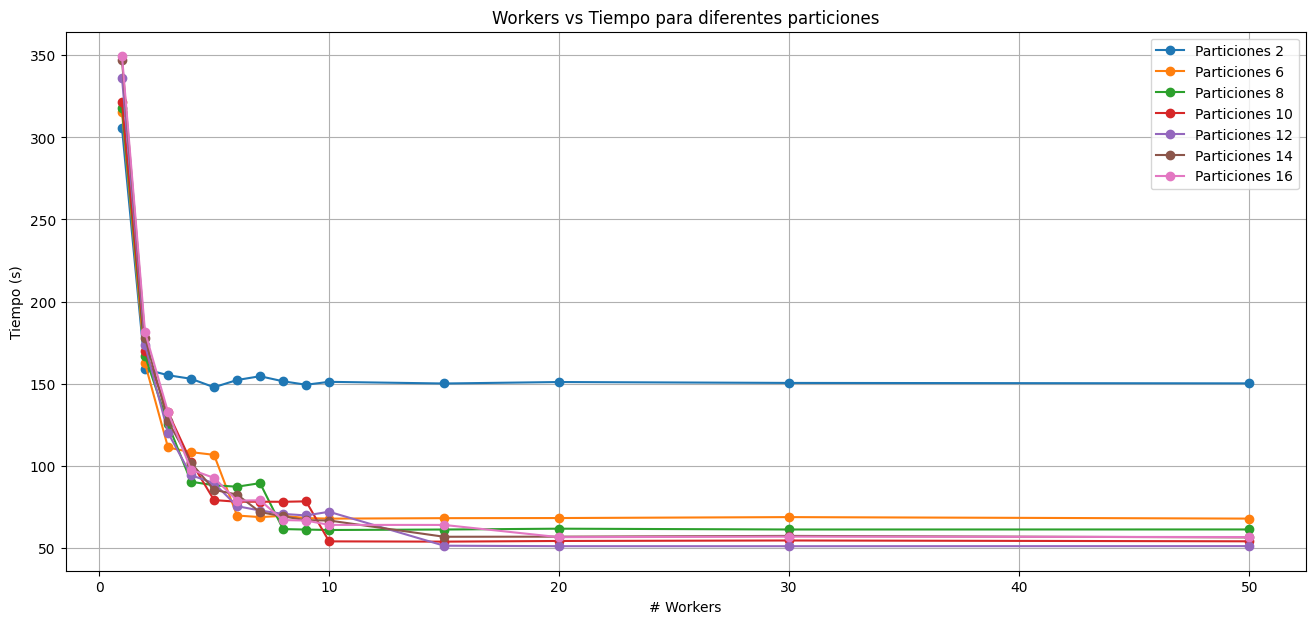

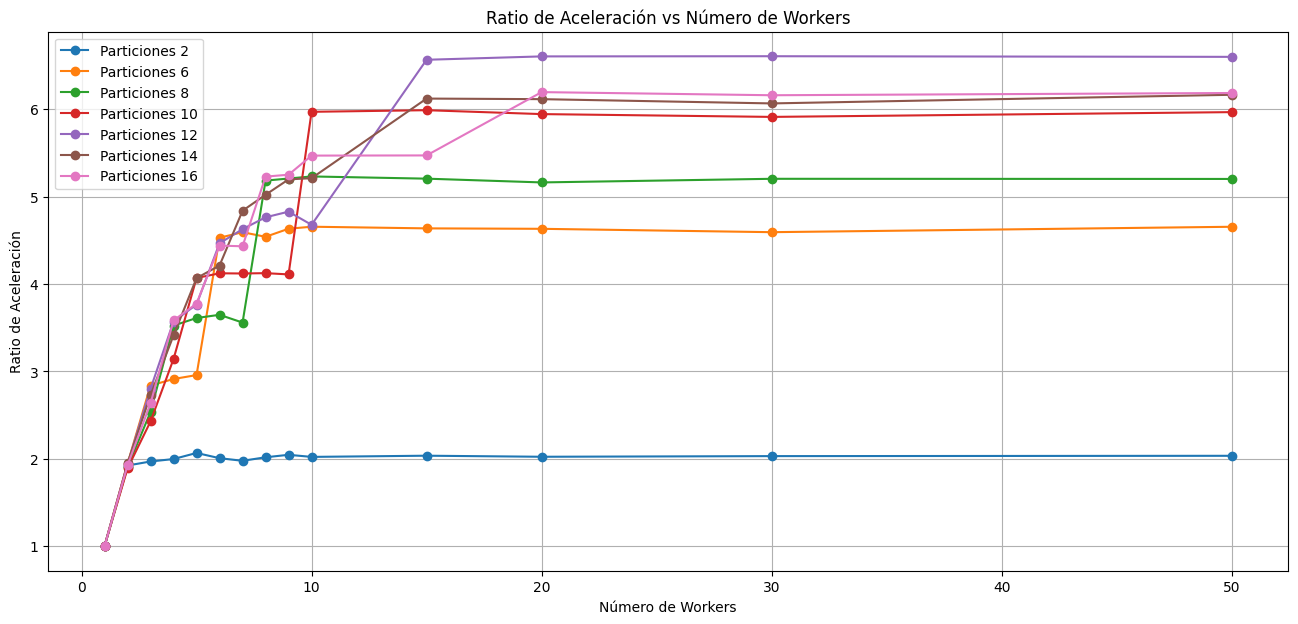

NameError: name 'inicial_incial' is not defined

In [5]:
inicial_inicial = time.time()
# Número de workers y particiones a probar
n_worker = 4
workers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 50]
particiones = [2, 6, 8, 10, 12, 14, 16]  # Puedes modificar este rango

try:
    sc.stop()
except:
    pass

plt.figure(figsize=(16, 7))
totals_por_particion = {}  # Almacenar tiempos por número de particiones

for p in particiones:
    totals = []  # Reiniciar la lista de tiempos para cada número de particiones
    
    for worker in tqdm(workers, desc=f"Workers (particiones={p})"):
        print(f"Workers: {worker}, Particiones: {p}")

        sc = SparkContext(f"local[{worker}]", "Name of the Program")
        n = readFile(file_path)   
        normalizado = normalize(n)
        normalizado=normalizado.repartition(p)

        inicio = time.time()
        w, b, costs = ej1_train(normalizado, 10, 1.5, p)  # Se cambia el número de particiones aquí
        fin = time.time()

        sc.stop()
        totals.append(fin - inicio)
    
    totals_por_particion[p] = totals  # Guardamos los tiempos de ejecución

    # Graficar en la misma figura
    plt.plot(workers, totals, marker='o', linestyle='-', label=f"Particiones {p}")

# Configurar la gráfica
plt.xlabel("# Workers")
plt.ylabel("Tiempo (s)")
plt.title("Workers vs Tiempo para diferentes particiones (million)")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_time_workers_million.png")
plt.show()

# ==========================
# Cálculo del Ratio de Aceleración
# ==========================

plt.figure(figsize=(16, 7))

for p in particiones:
    tiempos_workers_n = {w: totals_por_particion[p][i] for i, w in enumerate(workers)}
    tiempo_worker_1 = totals_por_particion[p][0]  # Tiempo con 1 worker
    ratios = {n: tiempo_worker_1 / t if t > 0 else None for n, t in tiempos_workers_n.items()}

    # Graficar el ratio de aceleración
    plt.plot(list(ratios.keys()), list(ratios.values()), marker='o', linestyle='-', label=f"Particiones {p}")

plt.xlabel("Número de Workers")
plt.ylabel("Ratio de Aceleración")
plt.title("Ratio de Aceleración vs Número de Workers/Particiones")
plt.legend()
plt.grid()
plt.savefig("results/Ej_2_speed_up_million.png")
plt.show()
final_final = time.time()
print(f"Tiempo de ejecución {(final_final - inicial_incial)/60} minutos")